## Funciones útiles

In [6]:
import os
import shutil
from google.colab import files

def uploadFiles(path='./'):
  """
  Function to upload files from the local PC to the Colab resources
  """
  
  # Build the absolute path to the cwd
  path = os.path.abspath(path)

  # Upload the files
  uploaded = files.upload()

  # Save the files
  for name, data in uploaded.items():
    shutil.move(name, path)

In [7]:
def savePickleFile(data, name, path='./'):
  """
  Function to save the received data
  """
  saveData = open(os.path.join(os.path.abspath(path), name), "wb")
  pickle.dump(data, saveData)
  saveData.close()

In [8]:
def loadPickleFile(path):
  """
  Function that loads the file from the received path 
  and return it
  """
  pickleFile = open(os.path.abspath(path), "rb")
  object = pickle.load(pickleFile)
  pickleFile.close()

  return object

# Cargar los sets de entrenamiento

In [4]:
# Make the dataset directory
!mkdir dataset

# Upload dataset files
uploadFiles('dataset')

Saving negative.txt to negative.txt
Saving positive.txt to positive.txt


# Entrenar el modelo y guardarlo en pickles

In [1]:
import re
import nltk
import pickle
import random
import numpy as np
from statistics import mode

from nltk.classify import ClassifierI
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.classify.scikitlearn import SklearnClassifier

from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier

In [2]:
# Needed instalation
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
# Instace the lemmatizer
lemmatizer = WordNetLemmatizer()

# Read the positive and negative datasets    
tweetsPositive = open("dataset/positive.txt", "r").read()
tweetsNegative = open("dataset/negative.txt", "r").read()

# Initialize needed list
allWords = []
documents = []

# Filter the allowed word types
# - J: Adject
# - R: Adverb
# - V Verb
allowed_word_types = ["J"]

# To delete all non alphabetic characters
regex = re.compile('[^a-zA-Z ]')

# Go through the list of positive tweets...
for tweet in tweetsPositive.split('\n'):
    # Leave just words
    tweet = regex.sub('', tweet)
    
    # Append the tuple with the label (tweet, positive)
    documents.append( (tweet, "pos") )
    
    # Tokenize by words and get tag of each word
    byWords = word_tokenize(tweet)
    taggedWords = nltk.pos_tag(byWords)
    
    # Check word for word to leave just the allowed type of words
    adjectFilter = list(filter(lambda word: word[1][0] in ["J"], taggedWords))
    verbFilter = list(filter(lambda word: word[1][0] in ["V"], taggedWords))

    # Apply lemmatizer to the words
    adjectFilter = list(map(lambda word: lemmatizer.lemmatize(word[0].lower(), pos="a"), adjectFilter))
    verbFilter = list(map(lambda word: lemmatizer.lemmatize(word[0].lower(), pos="v"), verbFilter))

    # Concatenate the words
    allWords += adjectFilter + verbFilter


# Go through the list of negative tweets...    
for tweet in tweetsNegative.split('\n'):
    # Leave just words
    tweet = regex.sub('', tweet)

    # Append the tuple with the label (tweet, negative)
    documents.append( (tweet, "neg") )

    # Tokenize by words and get tag of each word
    byWords = word_tokenize(tweet)
    taggedWords = nltk.pos_tag(byWords)

    # Check word for word to leave just the allowed type of words
    adjectFilter = list(filter(lambda word: word[1][0] in ["J"], taggedWords))
    verbFilter = list(filter(lambda word: word[1][0] in ["V"], taggedWords))

    # Apply lemmatizer to the words
    adjectFilter = list(map(lambda word: lemmatizer.lemmatize(word[0].lower(), pos="a"), adjectFilter))
    verbFilter = list(map(lambda word: lemmatizer.lemmatize(word[0].lower(), pos="a"), verbFilter))

    # Concatenate the words
    allWords += adjectFilter + verbFilter

In [4]:
# Print the number of collected words
print(len(allWords))

50697


In [9]:
# Make the directory to store the pickle files
!mkdir pickleFiles

# Save the final dataset with labels
savePickleFile(documents, "documents.pickle", './pickleFiles')

# Get the frequency distribution
allWords = nltk.FreqDist(allWords)
# Leave just the first 5000 words
wordFeatures = list(allWords.keys())[:10000]

# Save the word features
savePickleFile(wordFeatures, "wordFeatures5k.pickle", './pickleFiles')

mkdir: cannot create directory ‘pickleFiles’: File exists


In [10]:
def find_features(document):
    """
    Function to use the words as features and
    get a dictionary to know which words from the 
    frequency distribution list appear on the current
    sentence
    """
    words = word_tokenize(document)
    features = {}
    for word in wordFeatures:
        features[word] = (word in words)

    return features

# Get the feature dictionary by sentence
featureSets = [(find_features(rev), category) for (rev, category) in documents]
savePickleFile(featureSets, 'featuresets.pickle', path='./pickleFiles')

# Shuffle the dataset
random.shuffle(featureSets)
print("Number of feature sets: ", len(featureSets))

# Calculate the 80%
percentageVal = int(len(featureSets) * 0.80)

# Prepare the training and testing datasets
training_set = featureSets[:percentageVal]
testing_set = featureSets[percentageVal:]

Number of feature sets:  14002


In [11]:
# Print the size of trainin and testing set
print("Training Set: ", len(training_set))
print("Testing Set: ", len(testing_set))

Training Set:  11201
Testing Set:  2801


In [12]:
def trainModel(classifierAlgo, trainingSet, testingSet, name):
    """
    Function to train the modelo of the passed classifier,
    test it against the test dataset and sasve the pickle file
    """
    # Train it
    classifier = SklearnClassifier(classifierAlgo)
    classifier.train(trainingSet)
    # Save it
    savePickleFile(classifier, name, './pickleFiles')
    # Test it
    print("{} accuracy percent: {}".format(name, (nltk.classify.accuracy(classifier, testingSet)) * 100))

# Train the NLTK Naive Bayes algorithm and save it
classifier = nltk.NaiveBayesClassifier.train(training_set)
savePickleFile(classifier, "originalnaivebayes5k.pickle", './pickleFiles')
print("Original Naive Bayes Algo accuracy percent:", (nltk.classify.accuracy(classifier, testing_set)) * 100)

# Train the Multinomial Naive Bayes algorithm and save it
trainModel(MultinomialNB(), training_set, testing_set, "MNB_classifier5k.pickle")

# Train the Bernoulli Naive Bayes algorithm and save it
trainModel(BernoulliNB(), training_set, testing_set, "BernoulliNB_classifier5k.pickle")

# Train the Logistic Regression algorithm and save it
trainModel(LogisticRegression(), training_set, testing_set, "LogisticRegression_classifier5k.pickle")

# Train the Linear SVC algorithm and save it
trainModel(LinearSVC(), training_set, testing_set, "LinearSVC_classifier5k.pickle")

# Train the Stochastich Gradiant Descetn algorithm and save it
trainModel(SGDClassifier(), training_set, testing_set, "SGDC_classifier5k.pickle")

Original Naive Bayes Algo accuracy percent: 71.36736879685827
MNB_classifier5k.pickle accuracy percent: 70.40342734737594
BernoulliNB_classifier5k.pickle accuracy percent: 72.0813995001785
LogisticRegression_classifier5k.pickle accuracy percent: 71.83148875401642
LinearSVC_classifier5k.pickle accuracy percent: 69.93930739021778
SGDC_classifier5k.pickle accuracy percent: 70.581935023206


In [27]:
# Zip to download the files
!zip -r pickleFiles.zip pickleFiles/

  adding: pickleFiles/ (stored 0%)
  adding: pickleFiles/featuresets.pickle (deflated 73%)
  adding: pickleFiles/LinearSVC_classifier5k.pickle (deflated 48%)
  adding: pickleFiles/wordFeatures5k.pickle (deflated 56%)
  adding: pickleFiles/documents.pickle (deflated 55%)
  adding: pickleFiles/originalnaivebayes5k.pickle (deflated 78%)
  adding: pickleFiles/LogisticRegression_classifier5k.pickle (deflated 45%)
  adding: pickleFiles/SGDC_classifier5k.pickle (deflated 57%)
  adding: pickleFiles/BernoulliNB_classifier5k.pickle (deflated 74%)
  adding: pickleFiles/MNB_classifier5k.pickle (deflated 74%)


# Detección de sentimiento de tweets

In [14]:
class VoteClassifier(ClassifierI):
    def __init__(self, *classifiers):
        """ 
        Constructor method that saves the received list 
        of classifier algorithms
        """
        self._classifiers = classifiers

    def classify(self, features):
        """
        Method in charge of classifying with all the algorithms,
        saving their ouput and getting the mode as if it were a vote.
        """
        votesList = []
        for classifie in self._classifiers:
            v = classifie.classify(features)
            votesList.append(v)
        return mode(votesList)

    def confidence(self, features):
        """
        Returns the result of dividing the amount of algorithms that
        return the mode value divided by the total number of classifiers.
        """
        votesList = []
        for c in self._classifiers:
            v = c.classify(features)
            votesList.append(v)

        choiceVotes = votesList.count(mode(votesList))
        confValue = choiceVotes / len(votesList)
        return confValue

In [15]:
import nltk
import pickle
import random
from statistics import mode

from nltk.classify import ClassifierI
from nltk.tokenize import word_tokenize
from nltk.classify.scikitlearn import SklearnClassifier

from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC

def find_features(document):
    """
    Function to use the words as features and
    get a dictionary to know which words from the 
    frequency distribution list appear on the current
    sentence
    """
    # Token and tag the sentence
    byWords = word_tokenize(document)
    taggedWords = nltk.pos_tag(byWords)
    
    # Check word for word to leave just the allowed type of words
    adjectFilter = list(filter(lambda word: word[1][0] in ["J"], taggedWords))
    verbFilter = list(filter(lambda word: word[1][0] in ["V"], taggedWords))

    # Apply lemmatizer to the words
    adjectFilter = list(map(lambda word: lemmatizer.lemmatize(word[0].lower(), pos="a"), adjectFilter))
    verbFilter = list(map(lambda word: lemmatizer.lemmatize(word[0].lower(), pos="v"), verbFilter))

    
    # Get the features dictionary
    features = {}
    for word in (adjectFilter + verbFilter):
        features[word] = (word in words)

    return features

# Load the features sets
featuresSets = loadPickleFile("./pickleFiles/featuresets.pickle")

# Shuffle the dataset
random.shuffle(featuresSets)
print("Number of feature sets: ", len(featuresSets))

# Prepare the training and testing datasets
trainingSet = featuresSets[:10000]
testingSet = featuresSets[10000:]

# Load the original naive bayes
classifier = loadPickleFile("./pickleFiles/originalnaivebayes5k.pickle")

# Load the multinomial naive bayes
MNB_classifier = loadPickleFile("./pickleFiles/MNB_classifier5k.pickle")

# Load the bernoulli naive bayes
BernoulliNB_classifier = loadPickleFile("./pickleFiles/BernoulliNB_classifier5k.pickle")

# Load the bernoulli naive bayes
LogisticRegression_classifier = loadPickleFile("./pickleFiles/LogisticRegression_classifier5k.pickle")

# Load the linear svc
LinearSVC_classifier = loadPickleFile("./pickleFiles/LinearSVC_classifier5k.pickle")

# Load the linear svc
SGDC_classifier = loadPickleFile("./pickleFiles/SGDC_classifier5k.pickle")

# Build the Vote Classifier
votedClassifier = VoteClassifier(classifier, MNB_classifier, BernoulliNB_classifier,
                                LogisticRegression_classifier, LinearSVC_classifier)

print("Voted Classifier Algorithm Accuracy Percent:", (nltk.classify.accuracy(votedClassifier, testingSet)) * 100)

def sentiment(text):
  """
  Function to classify the received text with the voted classifier and returns
  the label and confidence of the classification
  """
  textFeatures = find_features(text)
  return votedClassifier.classify(textFeatures), votedClassifier.confidence(textFeatures)

Number of feature sets:  14002
Voted Classifier Algorithm Accuracy Percent: 81.83408295852074


In [17]:
# Experiment with the vote classifier
print(sentiment("Very happy with my new blog design - nice to see recent post and popular posts listed together, and it looks great! "))
print(sentiment("Sad, sad, sad. I don't know why but I hate this feeling  I wanna sleep and I still can't!"))

('pos', 1.0)
('neg', 1.0)


## Twitter

In [25]:
import json

from tweepy import Stream
from tweepy import OAuthHandler
from tweepy.streaming import StreamListener

# Consumer Key, Consumer Secret Ket
consumerKey = ""
consumerSecret = ""
# Access token, Access secret token.
accessToken = ""
accessSecret = ""

class listener(StreamListener):
  """
  Class to listen tweets
  """

  def on_data(self, data):
    """
    Function that defines what to do when 
    a tweet is listened
    """

    # Store the tweet data
    allData = json.loads(data)
    
    # Store the text from the tweet
    textTweet = allData["text"]
    
    # Get the sentiment and the confidence
    sentimentValue, confidenceValue = sentiment(textTweet)
    print(textTweet, sentimentValue, confidenceValue)

    # If the confidence of the classification is higher than 
    # 80% write the tweet text on the output file
    if (confidenceValue * 100) >= 80:
      outputFile = open("twitter-sentiment.txt","a")
      finalSentiment = sentimentValue + ' ' + str(confidenceValue)
      outputFile.write(finalSentiment)
      outputFile.write('\n')
      outputFile.write(textTweet)
      outputFile.write('\n')
      outputFile.write('\n')
      outputFile.close()

    return True

  def on_error(self, status):
    """
    Funtion that defines what to do when there is an error while
    listening tweets
    """
    print(status)

# Authenticate the app on twitter
auth = OAuthHandler(consumerKey, consumerSecret)
auth.set_access_token(accessToken ,  accessSecret)

# Start to listen the tweets
twitterStream = Stream(auth, listener())
twitterStream.filter(track=['sad'], languages=['en'])

RT @Giraffaloops: welcome 2 sad world https://t.co/oXJpLtdQCZ neg 0.8
RT @Fola_ldn: I pray Boga is able to find peace 💔💔😪 this is sooo sad https://t.co/n8mWc4i1Or neg 1.0
RT @venicitys: quarantine is just making me more sad tbh neg 1.0
@KTRTRS @Eatala_Rajender Very sad neg 1.0
I got so many closure wigs but I never really feel like my hair done unless I got a frontal wig on😭 thats so sad neg 1.0
@2EzBeno $hit Sad pos 1.0
i hate to say this but it might be 😭 neg 1.0
RT @davidplouffe: Sad but true. pos 1.0
RT @HeartAfire777: How ANYONE can’t see that this colossal blunder of a #PresidentialCandidate is not being used &amp; abused by the @DNC, his… neg 0.8
RT @BourtneySmith: Do you nap when you’re sad so your mind doesn’t have to be conscious or are you normal? neg 1.0
RT @AngrierWHStaff: Hey guys, the Trump hot mic video is almost certainly fake. 

I wouldn’t amplify. 

And yes, it’s really sad that just… neg 1.0
please i’m bawling rn why is this so sad to me??? i just want to give tokoy

KeyboardInterrupt: ignored

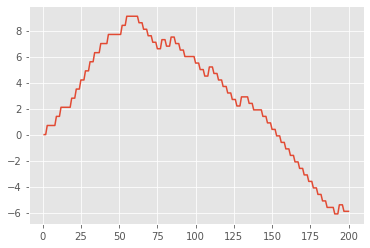

In [26]:
import time
from matplotlib import style
import matplotlib.pyplot as plt
import matplotlib.animation as animation

style.use("ggplot")

# Figure to plot
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)

def animate(i):
  """
  Function to animate the sentiment graph
  """
  # Get the data from the output file
  pullData = open("twitter-sentiment.txt","r").read()
  lines = pullData.split('\n')


  xar = []
  yar = []
  x = 0
  y = 0

  for l in lines[-200:]:
      x += 1
      if "pos" in l:
          y += 0.7
      elif "neg" in l:
          y -= 0.5

      xar.append(x)
      yar.append(y)
      
  ax1.clear()
  ax1.plot(xar,yar)
ani = animation.FuncAnimation(fig, animate, interval=1000)
plt.show()